In [7]:
import pandas as pd
import numpy as np
import re
from nlpUtils import aardvark as aa 
from numpy import random as rand

import seaborn as sns
import matplotlib.pyplot as plt

# import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification  # Check that these are the models I want
# from transformers import BertTokenizer, BertModel
# from transformers import BertForSequenceClassification, BertTokenizer
# from transformers import Trainer, TrainingArguments
# from nlp import load_dataset

# import wandb


from sklearn.metrics import f1_score, roc_curve, auc


In [ ]:
#pip install wandb

# Load the dataset

In [8]:
tweets_bert = pd.read_csv("temp_tweets_clean.csv", header=0, index_col=0)
print(tweets_bert.shape)
tweets_bert.tail()

(192, 19)


,id_stable,Date,Content,ContentClean,Labels,y_sent,y_stance,n_CapLetters,CapsRatio,AllCapWords,https,Mentions,Location,ReplyCount,RetweetCount,LikeCount,QuoteCount,Hashtags,Flag
187,61860,2021-09-30 09:26:10+00:00,"LISBON, Portugal (AP) — Girls from the Afghani...","LISBON, Portugal (AP) — Girls from the Afghani...",neutral / neutral,neutral,neutral,12,0.066298,"LISBON,, (AP)",https://t.co/OADALP4qVQ,NaN,"Davenport, IA",0,0,0,0,No hashtags,yes
188,103367,2021-08-29 20:40:58+00:00,@Sallyjoagain @dotslondon @PenFarthing @Nowzad...,"Truly barking mad, but Britain says 'Dogs welc...",angry / agree,angry,agree,4,0.047619,NaN,NaN,"@Sallyjoagain, @dotslondon, @PenFarthing, @Nowzad",Tirana Albania,1,0,0,0,No hashtags,yes
189,200943,2021-08-15 14:32:31+00:00,@ProudUCFAlumnae @ResisterSis1 @WalshFreedom Y...,Yet Biden already announced our withdrawal pri...,angry / neutral,angry,neutral,9,0.032727,SIV,NaN,"@ProudUCFAlumnae, @ResisterSis1, @WalshFreedom",English-speaking,0,0,0,0,No hashtags,yes
190,22583,2022-01-27 21:53:05+00:00,Thousands of Afghan evacuees have been welcome...,Thousands of Afghan evacuees have been welcome...,plea / agree,plea,agree,19,0.074219,"U.S., TAKE, ACTION:","https://t.co/MZVPINJ3kI, https://t.co/v7aV5nUbxq",NaN,English-speaking,0,5,26,0,['AfghanAdjustmentAct'],yes
191,51837,2021-10-22 05:57:22+00:00,Montana governor demands an halt to resettleme...,Montana governor demands an halt to resettleme...,neutral / neutral,neutral,neutral,2,0.019608,NaN,"https://t.co/GvtXtKwNco, https://t.co/u1nZpb4OU1",NaN,"Calgary, Alberta",0,0,3,1,No hashtags,yes


# Setup for BERT
Thanks to: https://medium.com/mlearning-ai/twitter-sentiment-analysis-with-deep-learning-using-bert-and-hugging-face-830005bcdbbf, https://www.youtube.com/watch?v=szczpgOEdXs

Using the bert-base-cased version; cased because all-caps matters in our case.

First, grab just the rows we will need.

In [9]:
berty = tweets_bert[["id_stable", "ContentClean", "y_sent"]].copy()
print(berty.shape)
berty.head()

(192, 3)


,id_stable,ContentClean,y_sent
0,106799,Sooooooo agree! Now then talk us through Afgha...,happy
1,50239,#Pretty awful Patel cannot stop a fly on shite...,angry
2,81751,And while helping resettlement the Western com...,neutral
3,63713,Biden's vetted Afghanistan refugees are commit...,disgust
4,145914,. We want all applications for refugee status ...,neutral


Find all the possible labels

In [10]:
pos_labels = berty["y_sent"].unique()
pos_labels

array(['happy', 'angry', 'neutral', 'disgust', 'fear', 'sad', 'plea',
       '? happy', 'hopeful', '? na', '? plea', '? fear'], dtype=object)

Add a column for the label transformed to numeric

In [13]:
label_dict = {'neutral':0, 'angry':1, 'fear':1, 'disgust':1, 'sad':1, 'plea':2, 'hopeful':3, 'happy':3, '? happy':3, '? na':0, '? plea':2, '? fear':1}
berty['label'] = berty.y_sent.replace(label_dict)
berty.head()

,id_stable,ContentClean,y_sent,label
0,106799,Sooooooo agree! Now then talk us through Afgha...,happy,3
1,50239,#Pretty awful Patel cannot stop a fly on shite...,angry,1
2,81751,And while helping resettlement the Western com...,neutral,0
3,63713,Biden's vetted Afghanistan refugees are commit...,disgust,1
4,145914,. We want all applications for refugee status ...,neutral,0


### Look at class distribution
Because unbalanced classes are an issue

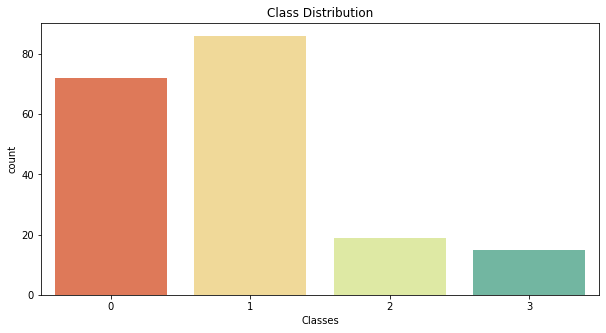

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot(x=berty["label"], palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution');

### Look at tweet length
Because BERT requires equal length sentences and we need to know where we want to cut/pad to.

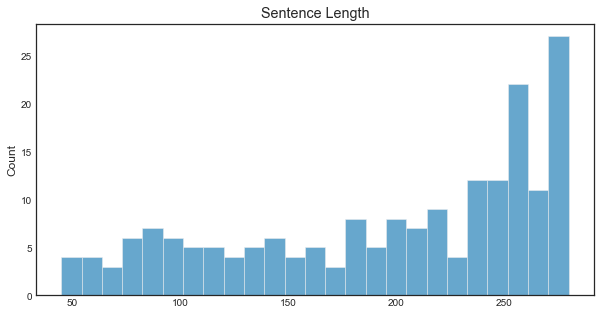

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in berty["ContentClean"]], bins=25)
plt.title('Sentence Length')
plt.style.use('ggplot') 
#plt.style.use('Solarize_Light2') 
plt.style.use('seaborn-white') 
plt.show()

# Train/Val/Test Split
Using stratify for imbalanced classes

In [ ]:
# from sklearn.model_selection import train_test_split

# #train test split
# X_train, X_val, y_train, y_val = train_test_split(berty.id_stable.values, berty.label.values, test_size = 0.15, random_state = 17, stratify = berty.label.values)


# Setup the BERT Tokenizer and Model
### Load the model

In [20]:
#tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-uncased')

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

# tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')    # Download vocabulary from S3 and cache.
# model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')    # Download model and configuration from S3 and cache.

# tokenizer = None
# model = None


### BERT-specific preprocessing

In [49]:
sentence = "Absolutely the worst"
tokens = tokenizer.tokenize(sentence) #, return_tensors='pt'
finished_tokens = ["[CLS]"] + tokens + ["[SEP]"] + ["[PAD]"] + ["[PAD]"]
attention_mask = [1 if i!= '[PAD]' else 0 for i in finished_tokens]
token_ids = tokenizer.convert_tokens_to_ids(finished_tokens)

print(tokens)
print(finished_tokens)
print(attention_mask)
print(token_ids)

# Converts token_id and attention mask to tensors
token_ids = torch.tensor(token_ids).unsqueeze(0)
attention_mask = torch.tensor(attention_mask).unsqueeze(0)

# result = model(tokens)
# result
# Thanks to "Getting Started with Google BERT"

['absolutely', 'the', 'worst']
['[CLS]', 'absolutely', 'the', 'worst', '[SEP]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 0, 0]
[101, 7078, 1996, 5409, 102, 0, 0]


### Get the word/token embeddings
NOTE: torch.Size([1, 7, 768]) indicates [batch_size, sequence_length, hidden_size], where 'hidden size' is the model-based representation size, 768 for BERT-base

Note: "instead of taking embeddings only from the final encoder layer (final hidden layer), we can also use embeddings from the other encoder layers," which may give better results (eg. concatenating the last four hidden). -"Getting Started with Google BERT


In [50]:
# FOR output_hidden_states = False
# hidden_rep, cls_head = model(token_ids, attention_mask = attention_mask)
# print(hidden_rep.shape) 

# FOR output_hidden_states = True
last_hidden_state, pooler_output, hidden_states = model(token_ids, attention_mask = attention_mask)
# returns: [last_hidden_state, pooler_output, hidden_states]
#   last_hidden_state[0][n]: returns the representation of the nth token in the final encoder layer
#   pooler_output: the representation of the [CLS] token, which holds the aggregate representation of the sentence.
#   hidden_states: a tuple containing 13 values holding the representation of all encoder layers (hidden layers), from the input embedding layer  to the final encoder layer 
#      hidden_states[n]: representations of all tokens from the nth encoder layer


In [51]:
rCLS = pooler_output
rCLS.shape

torch.Size([1, 768])

In [ ]:
text = "Replace me by any text you'd like."

encoded_input = tokenizer(text, return_tensors='pt')

output = model(**encoded_input)
